# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Overview](#overview)    
2. [The Quantum Teleportation Protocol](#how)       
3. [Simulating the Teleportation Protocol](#simulating)   
    3.1 [How will we Test this Result on a Real Quantum Computer?](#testing)   
    3.2 [Using the Simulated Statevector](#simulating-sv)     
    3.3 [Using the Simulated Counts](#simulating-fc)  
4. [Understanding Quantum Teleportation](#understanding-qt)
5. [Teleportation on a Real Quantum Computer](#real_qc)    
    5.1 [IBM hardware and Deferred Measurement](#deferred-measurement)    
    5.2 [Executing](#executing)    
6. [References](#references)



## 1. Overview <a id='overview'></a>

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

## 2. The Quantum Teleportation Protocol <a id='how'></a>
To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

![teleportation_doodle](images/tele1.jpg)

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [14]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler
backend_sim = AerSimulator()
simulator = AerSimulator()

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
sampler = BackendSampler(backend = backend_sim)
import numpy as np
from qiskit.visualization import plot_bloch_vector, plot_histogram
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator


import matplotlib.ticker as tck

/var/folders/r8/01h7mk295_qg6429pfv0cscc0000gn/T/ipykernel_46619/1152227622.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend = backend_sim)


In [15]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### Step 1
A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Telamon creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

In [16]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

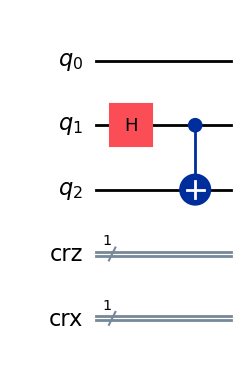

In [17]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw('mpl')

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

In [18]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

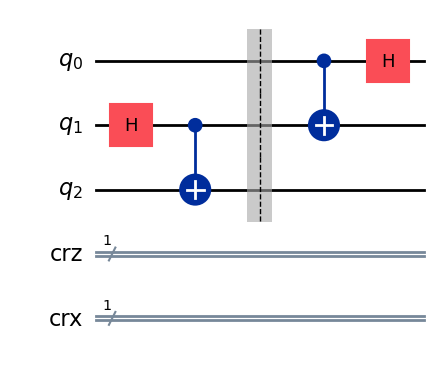

In [19]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw('mpl')

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [20]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

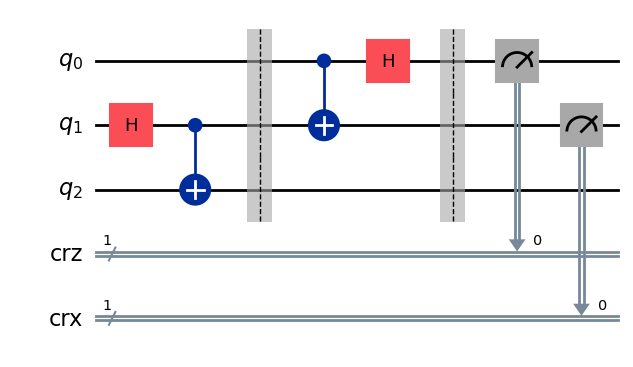

In [21]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw('mpl')

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [22]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

/var/folders/r8/01h7mk295_qg6429pfv0cscc0000gn/T/ipykernel_46619/1747897734.py:6: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(qubit).c_if(crx, 1) # Apply gates if the registers
/var/folders/r8/01h7mk295_qg6429pfv0cscc0000gn/T/ipykernel_46619/1747897734.py:7: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(qubit).c_if(crz, 1) # are in the state '1'


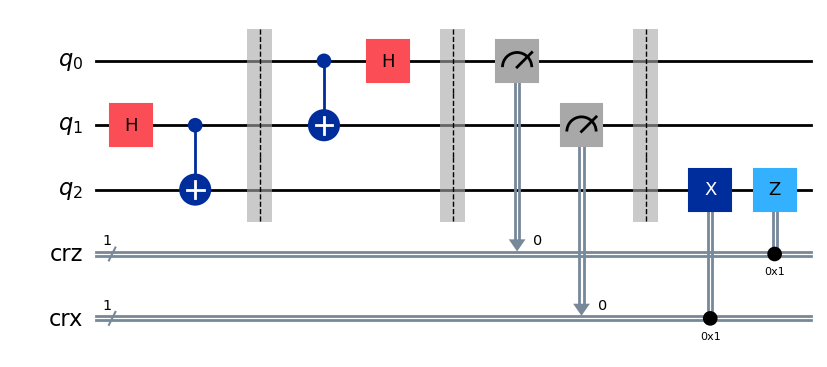

In [23]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw('mpl')

#### Testing the circuit

<IPython.core.display.Latex object>

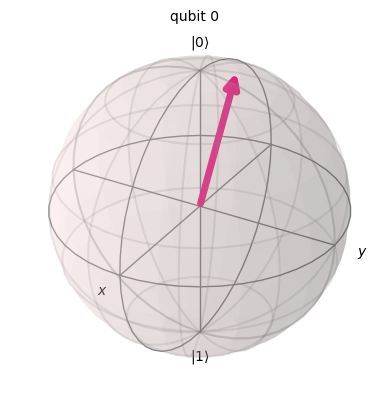

In [24]:
# let's first test our protocol studying the state vector
# initialize a random vector
from qiskit.quantum_info import random_statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.circuit.library import Initialize

theta = 2*np.pi * np.random.rand()
phi = 2*np.pi * np.random.rand()

psi = np.array([np.cos(theta/2), np.sin(theta/2) * np.exp(1j * phi)])

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
display(plot_bloch_multivector(psi))


/var/folders/r8/01h7mk295_qg6429pfv0cscc0000gn/T/ipykernel_46619/1747897734.py:6: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(qubit).c_if(crx, 1) # Apply gates if the registers
/var/folders/r8/01h7mk295_qg6429pfv0cscc0000gn/T/ipykernel_46619/1747897734.py:7: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(qubit).c_if(crz, 1) # are in the state '1'


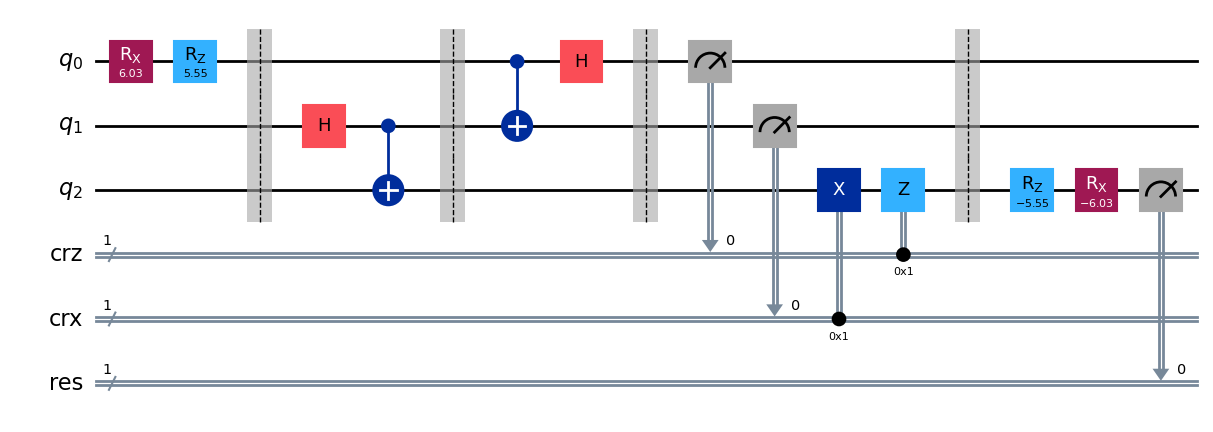

In [25]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
res = ClassicalRegister(1, name="res")
qc = QuantumCircuit(qr, crz, crx,res)

## STEP 0
# First, let's initialize Alice's q0
qc.rx(theta, 0)
qc.rz(phi, 0)
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)
qc.barrier()

#revert the initial rotations
qc.rz(-phi, 2)
qc.rx(-theta, 2)
qc.measure(2, 2)
# Display the circuit
qc.draw('mpl')

and we run our experiment:

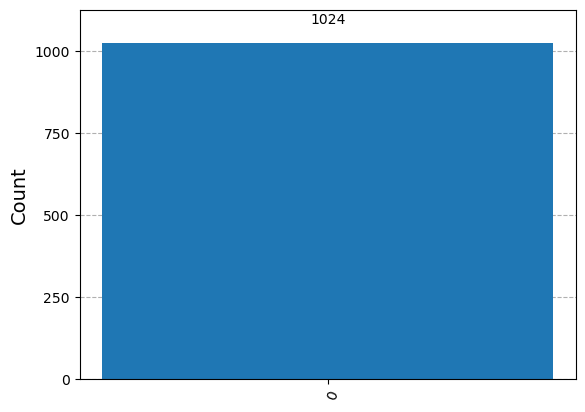

In [13]:
sim = AerSimulator()
result = sim.run(qc).result()
counts = result.get_counts()

marginal_counts_third = marginal_counts(counts, [2])
plot_histogram(marginal_counts_third)

In [ ]:
# Exercise: Run it on a real quantum computer and test this




In [ ]:
counts_teleported = marginal_counts(results.get_counts(),[2])

plot_histogram(counts_teleported)


In [ ]:
# Exercise: Run the codes developed last time to do state tomography and check that the state is teleported correctly.

In [ ]:
# Exercise: Implement the teleportation protocol using the IBMQ backend.

# Teleportation

In [ ]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")
c = ClassicalRegister(1, "c")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b,c)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)
    
protocol.barrier()
protocol.measure(ebit1, c)

display(protocol.draw(output="mpl"))

In [ ]:
results = simulator.run(protocol, shots=1000).result()
counts = marginal_counts(results.get_counts(),[0,1])

plot_histogram(counts)

In [ ]:
counts_teleported = marginal_counts(results.get_counts(),[2])

plot_histogram(counts_teleported)


In [ ]:
# Exercise: Run the codes developed last time to do state tomography and check that the state is teleported correctly.

In [ ]:
# Exercise: Retrieve the state at the end of the protocol and check that it is the same as the initial state, using the state tomography code (both on the simulator and on the real quantum computer).